# Adopt a Pet

You are in charge of an animal shelter and you want to predict if the animals you have in your possession can be adopted within 30 days or not.

The dataset at your disposal contains different information about the animals in the shelter: data about the breed or color, data about a cost, data about its health. You even have a short description written by the former owner and a picture of the animal.

We provide you only with the train part and a small test subset so that you can test the whole process.

<div class="alert-block alert-danger">
Deadline: Jannuary 15, 2022.
<br>
<br>
You must submit a zip archive to LMS that contains 3 documents:

- A pdf report that outlines the various stages of your work. You will insist on the different hyperparameters of your treatment and for each of them, you will specify on which ranges of values you have tested them. This report will also contain the precision obtained on the train set and on the test set.

- the executable notebook containing only the chosen hyper-parameters and not their research. You will leave in this one the execution traces.

- A ".joblib" file so that we can execute your code. Of course, the test dataset will be modified and only the predict function of the pipeline will be executed.
<br>
<br> 
The final grade will be based on the quality of the prediction (accuracy score) for 25% and the quality of the work for 75%.
</div>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-train-data" data-toc-modified-id="Load-train-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load train data</a></span><ul class="toc-item"><li><span><a href="#Load-the-images" data-toc-modified-id="Load-the-images-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Load the images</a></span></li><li><span><a href="#Compute-SIFT-detector-and-descriptors-for-one-image" data-toc-modified-id="Compute-SIFT-detector-and-descriptors-for-one-image-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Compute SIFT detector and descriptors for one image</a></span></li><li><span><a href="#Extract-features-and-build-BOFs" data-toc-modified-id="Extract-features-and-build-BOFs-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Extract features and build BOFs</a></span></li></ul></li><li><span><a href="#Build-a-basic-model" data-toc-modified-id="Build-a-basic-model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Build a basic model</a></span></li><li><span><a href="#Evaluation-of-the-model" data-toc-modified-id="Evaluation-of-the-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Evaluation of the model</a></span></li></ul></div>

In [ ]:
# Importing essential libraries
import os
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
%matplotlib inline

## Load train data

In [ ]:
path = "https://www.i3s.unice.fr/~riveill/dataset/petfinder-adoption-prediction/"

In [ ]:
breeds = pd.read_csv(path+'breed_labels.csv')
colors = pd.read_csv(path+'color_labels.csv')
states = pd.read_csv(path+'state_labels.csv')

train = pd.read_csv(path+'train.csv')

train['dataset_type'] = 'train'

In [ ]:
len(train) # checking the size of the training data

8168

In [ ]:
if 'dataset_type' in train.columns:
    train = train.drop(labels='dataset_type', axis=1)
train.columns

Index(['Type', 'Age', 'Gender', 'Color1', 'Color2', 'Color3', 'MaturitySize',
       'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized', 'Health', 'Fee',
       'Description', 'Images', 'Breed', 'target'],
      dtype='object')

In [ ]:
y_train = train['target']
X_train = train.drop(['target'], axis=1)
X_train.head() # checking the first 5 rows of the training dataframe

,Type,Age,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Fee,Description,Images,Breed
0,Cat,12.0,Female,White,Unknown,Unknown,Medium,Yes,Unknown,Unknown,Unknown,Healthy,0.0,We got Luna when she was a kitten in Feb 15'. ...,880e13787-4.jpg,Domestic_Short_Hair
1,Cat,4.0,Male,Golden,White,Unknown,Medium,Yes,No,Yes,No,Healthy,0.0,Ginger Boy was found starving and hungry so I ...,7abe9a0a1-2.jpg,Domestic_Short_Hair
2,Cat,12.0,Female,Black,Golden,White,Medium,No,No,No,No,Healthy,0.0,An indoor cat with nice green/ yellowish eyes....,605d07d33-5.jpg,Domestic_Medium_Hair
3,Dog,60.0,Male,Black,Gray,White,Medium,No,Yes,Unknown,Unknown,Healthy,0.0,My dog name called boo. He is a male. I feedin...,7ed568ab9-1.jpg,Schnauzer
4,Cat,36.0,Female,Cream,Gray,White,Large,No,No,No,Yes,Healthy,0.0,"1) Foxy is a stray cat which I feed regularly,...",8969b314b-5.jpg,Siamese


In [ ]:
y_train.head() # cheking the label column

0     True
1    False
2     True
3    False
4     True
Name: target, dtype: bool

In [ ]:
# Setting up columns lists by type of variables
cat_cols = ['Type', 'Gender', 'Breed', 'Color1', 'Color2', 'Color3', 
       'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health']
num_cols = ['Age', 'Fee']
txt_cols = ['Description']
img_cols = ['Images']

In [ ]:
X_train[num_cols].describe() # checking the main statistics of the numerical variables

,Age,Fee
count,8168.000000,8168.000000
mean,12.108962,24.675686
std,19.780258,82.339465
min,0.000000,0.000000
25%,2.000000,0.000000
50%,4.000000,0.000000
75%,12.000000,0.000000
max,255.000000,2000.000000


In [ ]:
display(X_train[cat_cols].describe()) # checing the main statistics of the categorical variables
nbr_onehot_features = np.sum(np.array(X_train[cat_cols].describe().loc['unique'])) # count of OneHotEncoded Feature for later use

,Type,Gender,Breed,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health
count,8168,8168,8168,8168,8168,8168,8168,8168,8168,8168,8168,8168
unique,2,2,152,7,7,6,4,3,3,3,3,3
top,Dog,Female,Mixed_Breed,Black,Unknown,Unknown,Medium,Yes,Yes,Yes,No,Healthy
freq,4904,4570,3437,3674,2868,6434,5711,4899,3742,5171,5247,7873


### Load the images

In [ ]:
# Build the image list of the training set 
img_dir = "train_images/"
X_train['Images'] = [path+img_dir+img for img in train['Images']]

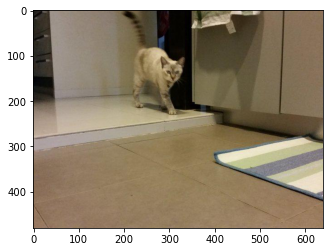

In [ ]:
from skimage import io

# Read the first image of the list
img = io.imread(X_train['Images'][0])
# have a look to the image
plt.imshow(img)

### Compute SIFT detector and descriptors for one image

In [ ]:
# convert the image to grey levels 
import cv2

gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

In [ ]:
# compute SIFT detector and descriptors
sift = cv2.SIFT_create()
kp,des = sift.detectAndCompute(gray,None)

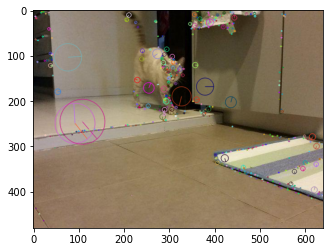

In [ ]:
# plot image and descriptors
cv2.drawKeypoints(img,kp,img,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img)

### Extract features and build BOFs

In [ ]:
# First step, extract the SIFTs of each image
# Be carefull: very long process

def extract_SIFT(img_lst):
    nbSIFTs = 0    # Nomber of SIFTs
    SIFTs = []  # List of SIFTs descriptors 
    #dimImgs = []   # Nb of descriptors associated to each images

    for pathImg in tqdm(img_lst, position=0, leave=True): 
        img = io.imread(pathImg)
        if len(img.shape)==2: # this is a grey level image
            gray = img
        else: # we expect the image to be a RGB image or RGBA
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        sift = cv2.SIFT_create()
        kp, des = sift.detectAndCompute(gray, None)
        if len(kp) == 0 and img.shape[2]==4: #some images are mask on alpha channel: we thus extract this channel if not kpts have been detected
            gray = img[:,:,3]
            sift = cv2.SIFT_create()
            kp, des = sift.detectAndCompute(gray, None)
        
        nbSIFTs += des.shape[0]
        SIFTs.append(des)
        #dimImgs.append(des.shape[0])
    return nbSIFTs, SIFTs#, dimImgs

In [ ]:
# Step 2: clusterize the SIFT
from sklearn.cluster import MiniBatchKMeans

def clusterize(SIFTs, nb_img_features=5, verbose=False):
    clusterizer = MiniBatchKMeans(n_clusters=nb_img_features)   # nb_img_features is a hyperparameter
    # learning of the clustering
    flat_list = SIFTs[0]
    for des in SIFTs[1:]:
        flat_list = np.concatenate((flat_list, des))
        if verbose:
            print("shape:", des.shape, flat_list.shape)
    clusterizer.fit(flat_list)
    # we now know the label of each SIFT descriptor
    return clusterizer

In [ ]:
# Step 3: build the BOW representation of each images (i.e. construction of the BOFs)

def build_BOFs(SIFTs, clusterizer, verbose=False):
    ok, nok = 0, 0
    #BOF initialization
    nb_img_features = clusterizer.get_params()['n_clusters']
    BOFs = np.empty(shape=(0, nb_img_features), dtype=int)

    # Build label list
    flat_list = SIFTs[0]
    for des in SIFTs[1:]:
        flat_list = np.concatenate((flat_list, des))
        if verbose:
            print("shape:", des.shape, flat_list.shape)
    labels = clusterizer.predict(flat_list)

    # loop on images
    i = 0 # index for the loop on SIFTs
    for des in SIFTs:
        #initialisation of the bof for the current image
        tmpBof = np.array([0]*nb_img_features)
        j = 0
        # for every SIFT of the current image:
        nbs = des.shape[0]
        while j < nbs:
            tmpBof[labels[i]] += 1
            j+=1
            i+=1
        BOFs = np.concatenate((BOFs, tmpBof.reshape(1,-1)), axis=0)
    if verbose:
        print("BOFs : ", BOFs)
    
    return BOFs

In [ ]:
from sklearn.base import BaseEstimator,TransformerMixin

def list_comparaison(l1, l2):
    if not l1 is None \
        and not l2 is None \
        and len(l1)==len(l2) \
        and len(l1)==sum([1 for i,j in zip(l1, l2) if i==j]):
        return True
    return False
    
class BOF_extractor(BaseEstimator,TransformerMixin): 
    X = None
    SIFTs = None
    nbSIFTs = 0
    
    def __init__(self, nb_img_features=10, verbose=False):
        self.nb_img_features = nb_img_features
        self.verbose = verbose
        self.path = path
        if self.verbose:
            print("BOF.init()")
        
    def fit(self, X, y=None):
        if self.verbose:
            print("BOF.fit()")
        if list_comparaison(X, self.X):
            SIFTs = self.SIFTs 
            nbSIFTs = self.nbSIFTs
        else:
            if self.verbose:
                print("extract_SIFT")
            nbSIFTs, SIFTs = extract_SIFT(X)
        self.X = X
        self.SIFTs = SIFTs 
        self.nbSIFTs = nbSIFTs
        self.clusterizer = clusterize(SIFTs, self.nb_img_features, self.verbose)
        
    def transform(self, X, y=None):
        if self.verbose:
            print("BOF.transform()")
        if list_comparaison(X, self.X):
            SIFTs = self.SIFTs 
            nbSIFTs = self.nbSIFTs
        else:
            if self.verbose:
                print("extract_SIFT")
            nbSIFTs, SIFTs = extract_SIFT(X)

        if self.verbose:
            print("nbSIFTs:", nbSIFTs)
        return build_BOFs(SIFTs, self.clusterizer, self.verbose)
    
    def fit_transform(self, X, y=None):
        if self.verbose:
            print("BOF.fit_transform()")
        if list_comparaison(X, self.X):
            SIFTs = self.SIFTs 
            nbSIFTs = self.nbSIFTs
        else:
            if self.verbose:
                print("extract_SIFT")
            nbSIFTs, SIFTs = extract_SIFT(X)
        self.X = X
        self.SIFTs = SIFTs 
        self.nbSIFTs = nbSIFTs
        self.clusterizer = clusterize(SIFTs, self.nb_img_features, self.verbose)
        return build_BOFs(SIFTs, self.clusterizer, self.verbose)

In [ ]:
test = pd.read_csv(path+"test.csv")
y_test = test['target']
X_test = test.drop(['target'], axis=1)

img_dir = "test_images/"
X_test['Images'] = [path+img_dir+img for img in test['Images']]
len(X_test)

250

## Build a basic model

There are much more interesting things in the dataset and I'm going to explore them, but for now let's build a simple model as a baseline.

In [ ]:
# Importing functions and classes frm scikit-learn to build a machine learning pipeline.
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Instantiating a OneHotEncoder to transform the categorical variables
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
# Instantiating a Standard scaler to scale the numerical features by calculating their Z_score
numerical_preprocessor = StandardScaler()
#Instantiating a TF-IDF vectorizer to extract numerical features from text
text_preprocessor = TfidfVectorizer()
# Instantiating the BOF extractor defined earlier
image_preprocessor = BOF_extractor(nb_img_features=5, verbose=False)

# Instantiating PCA class to perform dimentionality reduction before passing to the training step
pca = TruncatedSVD(n_components=1000) 

# Setting up a column tansformer to perform the necessary data preprocessing steps before training
preprocessor = ColumnTransformer([
    ("categorical_encoding", categorical_preprocessor, cat_cols),
    ("numerical_encoding", numerical_preprocessor, num_cols),
    ("text_encoding", text_preprocessor, 'Description'),
    ("image_encoding", image_preprocessor, 'Images'),
])

# Instantiating the classifier to be trained as a final step of the pipeline
classifier = GradientBoostingClassifier(verbose=1)

# Creating a pipeline instance using the defined steps
model = make_pipeline(preprocessor, pca, classifier)

In [ ]:
# Creating a dictionary that contains the set of optimal hyperparameters obtained via HalvingGridSeachCV
gs_best_param={'columntransformer__image_encoding__nb_img_features': 20,
 'gradientboostingclassifier__loss':'exponential',
 'gradientboostingclassifier__max_depth':7,
 'gradientboostingclassifier__n_estimators':150,
 'gradientboostingclassifier__learning_rate':0.01,
 'truncatedsvd__n_components': 100}

# Setting up the optimal parameters of the pipeline
model.set_params(**gs_best_param)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('categorical_encoding',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Type', 'Gender', 'Breed',
                                                   'Color1', 'Color2', 'Color3',
                                                   'MaturitySize', 'FurLength',
                                                   'Vaccinated', 'Dewormed',
                                                   'Sterilized', 'Health']),
                                                 ('numerical_encoding',
                                                  StandardScaler(),
                                                  ['Age', 'Fee']),
                                                 ('text_encoding',
                                                  TfidfVectorizer(),
                                                  'Description

In [ ]:
# Training the pipeline using the whole training set
model.fit(X_train, y_train)

100%|██████████| 8168/8168 [1:04:04<00:00,  2.12it/s]


      Iter       Train Loss   Remaining Time 
         1           0.9974            1.10m
         2           0.9953            1.03m
         3           0.9932           59.92s
         4           0.9911           58.78s
         5           0.9890           57.85s
         6           0.9869           57.21s
         7           0.9849           56.56s
         8           0.9829           56.06s
         9           0.9809           55.56s
        10           0.9789           55.01s
        20           0.9602           50.54s
        30           0.9429           46.51s
        40           0.9269           42.60s
        50           0.9117           38.70s
        60           0.8974           34.82s
        70           0.8835           30.93s
        80           0.8709           27.08s
        90           0.8577           23.20s
       100           0.8453           19.35s


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('categorical_encoding',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Type', 'Gender', 'Breed',
                                                   'Color1', 'Color2', 'Color3',
                                                   'MaturitySize', 'FurLength',
                                                   'Vaccinated', 'Dewormed',
                                                   'Sterilized', 'Health']),
                                                 ('numerical_encoding',
                                                  StandardScaler(),
                                                  ['Age', 'Fee']),
                                                 ('text_encoding',
                                                  TfidfVectorizer(),
                                                  'Description

In [ ]:
# Save the model
from joblib import dump, load

dump(model, 'michel.joblib') 

['michel.joblib']

## Evaluation of the model

<div class="alert alert-block alert-danger">
We will only execute the following cells.
</div>

In [ ]:
# Importing the testing data
test = pd.read_csv(path+"test.csv")

y_test = test['target']
X_test = test.drop(['target'], axis=1)

img_dir = "test_images/"
X_test['Images'] = [path+img_dir+img for img in test['Images']]
print("Test size:", len(X_test))

# Loading of the trained pipeline
model = load('michel.joblib') 

# Predicting the labels on the training set
y_pred = model.predict(X_train)
print("ACC on train", accuracy_score(y_train, y_pred))

# Predicting the labels on the test set
y_pred = model.predict(X_test)
print("ACC on test", accuracy_score(y_test, y_pred))

Test size: 250
ACC on train 0.8448824681684622


100%|██████████| 250/250 [04:36<00:00,  1.11s/it]


ACC on test 0.608
